# Monthly vegetation condition anomalies

* **Products used:**
[ndvi_climatology_ls](https://explorer.digitalearth.africa/ndvi_climatology_ls), [crop_mask_eastern](https://explorer.digitalearth.africa/crop_mask_eastern), [wofs_ls_summary_alltime](https://explorer.digitalearth.africa/wofs_ls_summary_alltime),
[s2_ls2](https://explorer.digitalearth.africa/), [ls8_sr](https://explorer.digitalearth.africa/ls8_sr), [ls9_sr](https://explorer.digitalearth.africa/ls9_sr)

## Background
Understanding how the vegetated landscape responds to longer-term environmental drivers such as the El Nino Southern Oscillation (ENSO) or climate change, requires the calculation of standardised anomalies. Standardised anomalies subtract the long-term mean from an observation of interest and then divide the result by the long-term standard deviation, thus removing seasonal variability and highlighting change related to longer-term drivers.


### Description

This notebook will calculate monthly _standardised_ NDVI anomalies for any given month and year, and relies on DE Africa's 30 metre resolution [NDVI climatology](https://docs.digitalearthafrica.org/en/latest/data_specs/NDVI_Climatology_specs.html) product to define the baseline vegetation condition. Sentinel-2, and Landsat 8/9 are used to calculate the monthly mean NDVI for the month of interest. The standardised anaomaly is then calculated as:
        
\begin{equation}
\text{Standardised anomaly }=\frac{x-m}{s}
\end{equation}

where $x$ is NDVI for the month of interest, $m$ is the long-term mean, and $s$ is the long-term standard deviation.

The following steps are taken in the notebook:
1. Load a polygon for the country of interest (a geojson with country boundaries is already provided)
2. Load cloud masked Sentinel-2 and Landsat satellite data
3. Preprocess the satellite data so we have one continuous, noise free time-series of NDVI.
4. Create mask of the country boundary
5. Load DE Africa's NDVI climatology product
6. Use WOfS to remove waterbodies from the region
7. Calculate standardised NDVI anomalies
8. Plot the result
9. Load DE Africa's crop-mask for the region
10. Plot NDVI anomalies for regions only within the crop-mask



## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils import masking
from datacube.utils.geometry import Geometry, CRS
from deafrica_tools.spatial import xr_rasterize

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map
from deafrica_tools.dask import create_local_dask_cluster

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38845 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:34251 Dashboard: /user/mickwelli@bigpond.com/proxy/38845/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="Vegetation_anomalies")

### Analysis parameters

The following cell sets important parameters for the analysis:

<!-- * `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.2` or lower. -->

* `country`: The country over which to load data, e.g. `'Uganda'`. The full list of Africa countries can be found in cell `[6]`
* `year`: The year for which we will calculate the standardised anomaly, e.g. `'2022'`
* `month`: The month for which we will calculate the standardised anomaly, written as a lower-case three letter abbreviation e.g `'jan'`,`'feb'` etc. This is because the `ndvi_climatology_ls` product's measurements are stored as `'mean_jan'`, `'mean_feb'` etc.
* `crop_mask`: Depending on where you are loading data, you can change the crop mask to load with this parameter. Use [explorer](https://explorer.digitalearth.africa/products) to find which crop mask covers which region of Africa.
* `resolution`: The x and y cell resolution of the satellite data and `ndvi_climatology_ls` data, e.g. `(-30, 30)` will load data at its native 30 x 30m resolution. If loading a large area, then increase the resolution so the data will fit into memory. For example, if trying to find the NDVI anomaly for a large country, consider increasing the resolution to `(-210,210)`.
* `dask_chunks`:  the size of the dask chunks, dask breaks data into manageable chunks that can be easily stored in memory, e.g. `dict(x=1000,y=1000)`

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.


In [4]:
# Select a country
country = "Uganda"

# year and month for anomaly
year = '2022'
month = 'jan'

# the crop mask to use
crop_mask = 'crop_mask_eastern'

# pixel resolution can got as low as (-30,30) metres,
# but make larger for big areas. 
resolution = (-120, 120)

# how to chunk the dataset for use with dask
dask_chunks = dict(x=1000,y=1000)


### Load the African Countries shapefile

This shapefile contains polygons for the boundaries of African countries and will allows us to calculate NDVI anomalies within a chosen country

In [5]:
african_countries = gpd.read_file('../Supplementary_data/Rainfall_anomaly_CHIRPS/african_countries.geojson')

### List countries

You can change the country in the analysis parameters cell to any African country. A complete list of countries is printed below.

In [6]:
print(np.unique(african_countries.COUNTRY))

['Algeria' 'Angola' 'Benin' 'Botswana' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Cape Verde' 'Central African Republic' 'Chad' 'Comoros'
 'Congo-Brazzaville' 'Cote d`Ivoire' 'Democratic Republic of Congo'
 'Djibouti' 'Egypt' 'Equatorial Guinea' 'Eritrea' 'Ethiopia' 'Gabon'
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Kenya' 'Lesotho' 'Liberia'
 'Libya' 'Madagascar' 'Malawi' 'Mali' 'Mauritania' 'Morocco' 'Mozambique'
 'Namibia' 'Niger' 'Nigeria' 'Rwanda' 'Sao Tome and Principe' 'Senegal'
 'Sierra Leone' 'Somalia' 'South Africa' 'Sudan' 'Swaziland' 'Tanzania'
 'Togo' 'Tunisia' 'Uganda' 'Western Sahara' 'Zambia' 'Zimbabwe']


## Setup polygon

The country selected needs to be transformed into a geometry object to be used in the `load_ard` function.

In [7]:
idx = african_countries[african_countries['COUNTRY'] == country].index[0]
geom = Geometry(geom=african_countries.iloc[idx].geometry, crs=african_countries.crs)

## Load and process cloud-masked satellite data
The first step in this analysis is to load in Landsat 8/9 and Sentinel-2 data for the country we've picked, and for the month of the anomaly we want to assess. 
The code below uses the `load_ard` function to load in data from Landsat 8/9 and Sentinel-2 satellites for the area and time specified.
For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).

Firstly, we will set up a dictionary that maps the abbreviated month name, `month` to a string number, allowing us to load data for that month from the datacube. The second dictionary, `query` maps the parameters we provided above to the `datacube.load()` parameters.

In [8]:
# map months to string numbers
months = {
    "jan": "01",
    "feb": "02",
    "mar": "03",
    "apr": "04",
    "may": "05",
    "jun": "06",
    "jul": "07",
    "aug": "08",
    "sep": "09",
    "oct": "10",
    "nov": "11",
    "dec": "12",
}

# Create the 'query' dictionary object for loading data form the datacube
query = {
    "geopolygon": geom,
    "time": year + "-" + months[month],
    "resolution": resolution,
    "output_crs": "epsg:6933",
    "dask_chunks": dask_chunks,
}

Now let's load the satellite data

In [9]:
# Load available data Landsat 8 and 9
ds_ls = load_ard(dc=dc, 
              products=['ls8_sr', 'ls9_sr'], 
              group_by='solar_day',
              measurements= ['red','nir'],
              resampling={'pixel_quality':'nearest', '*':'average'},
              mask_filters=[("opening", 3),("dilation", 3)], #improve cloud-mask
              verbose=False,
              **query)

# Load available sentinel2
ds_s2 = load_ard(dc=dc, 
              products=['s2_l2a'],
              measurements=['red','nir_2'], #use nir narrow to match with LS8 nir  
              group_by='solar_day',   
              resampling={'pixel_quality':'nearest', '*':'average'},
              mask_filters=[("opening", 3),("dilation", 3)], #improve cloud-mask
              verbose=False,
              **query)


/home/jovyan/Tools/deafrica_tools/datahandling.py:474: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  pq_mask = xr.ufuncs.logical_or(pq_mask, pq_mask)
/env/lib/python3.8/site-packages/xarray/core/dataarray.py:3088: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self.variable, other_variable)
/env/lib/python3.8/site-packages/xarray/core/variable.py:2420: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  f(self_data, other_data) if not reflexive else f(other_data, self_data)


## Preprocess satellite data

Here we perform a number of steps to get the satellite data into the format we need for calculating an NDVI anomaly.
1. Rename the `'nir_2'` band in Sentinel-2 to `'nir'` so the `calculate_indices` function will understand to calculate NDVI using `'nir_2'`.
2. Calculate NDVI on both Landsat and Sentinel-2 data, then we concatenate the two time-series together.
3. Now that we one continous time-series of NDVI, we can clean the time-series by removing data that is outside the range 0-1, and minimize the impact of noise/missed cloud by running a temporal rolling mean filter with a small window size
4. Calculate the mean NDVI for the month.

> Note that this cell will take several minutes to run (depending on size and resolution of the datasets) as here we trigger all of the calculations we've listed up to this point with the `.compute()` method

In [10]:
#rename to trick 'calculate_indices'
ds_s2 = ds_s2.rename({'nir_2':'nir'})

#calculate NDVI
ndvi_s2 = calculate_indices(ds_s2, 'NDVI', collection='s2', drop=True)
ndvi_ls = calculate_indices(ds_ls, 'NDVI', collection='c2', drop=True)

#concatente together
ndvi = xr.concat([ndvi_ls,ndvi_s2], dim='time').sortby('time')

# Remove NDVI's that aren't between 0 and 1
ndvi = ndvi.where((ndvi >= 0) & (ndvi <= 1))

# smooth out noise from missed cloud
ndvi = ndvi.rolling(time=3, min_periods=1).mean()

# summarise into a monthly mean
month_mean = ndvi.NDVI.mean('time').compute()

Dropping bands ['red', 'nir']
Dropping bands ['red', 'nir']


## Create a rasterized mask of the country boundary


In [11]:
african_countries = african_countries.to_crs('epsg:6933')
mask = xr_rasterize(african_countries[african_countries['COUNTRY'] == country], ds_ls)

## Load DE Africa's NDVI climatologies


In [12]:
ndvi_clim = dc.load(
    product="ndvi_climatology_ls",
    like=ds_ls.geobox,
    measurements=['mean_'+month, 'stddev_'+month, 'count_'+month],
    dask_chunks=dask_chunks,
).squeeze()

### Make a quality assurance mask where clear observation count is low

Due to the inconsistent data availability of Landsat 5 over equatorial Africa, and due to persistent cloud coverage over these same regions, the quality of the long-term NDVI baseline is poor in in some parts of Africa. We recommend not using relying on the product in locations where the clear obervation count is less than ~20-30 observations. Below this, the standard deviation layers are prone to data artefacts owing to temporal smoothing operations performing poorly on sparse datasets, and residual cloudy pixels not being sufficiently ‘averaged out’ by a decent volume of input data.

In [13]:
min_num_obs = 20

In [14]:
qa_mask = ndvi_clim['count_'+month] >= min_num_obs

# remove pixels where obs are < min_num_obs
ndvi_clim = ndvi_clim.where(qa_mask).compute()

## Mask both datasets with country mask

In [15]:
#mask with country boundary
ndvi_clim = ndvi_clim.where(mask==1)
month_mean = month_mean.where(mask==1)

## Remove water bodies

This will constrain all the NDVI anomaly observations to just the land mass

In [16]:
#load wofs
wofs = dc.load(product='wofs_ls_summary_alltime',
               measurements=['frequency'],
               like=ds_ls.geobox,
               dask_chunks=dask_chunks
              ).frequency.squeeze()

#set masked terrain regions to 0 
wofs = xr.where(xr.ufuncs.isnan(wofs), 0, wofs)

#threshold to create waterbodies mask
wofs = (wofs < 0.5)

#mask with country boundary
wofs = wofs.where(mask).compute()

/tmp/ipykernel_833/2600607567.py:9: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  wofs = xr.where(xr.ufuncs.isnan(wofs), 0, wofs)
/env/lib/python3.8/site-packages/xarray/core/dataarray.py:3068: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


In [17]:
#mask with wofs boundary
ndvi_clim = ndvi_clim.where(wofs)
mean_clim = ndvi_clim['mean_'+month].where(wofs)
std_clim = ndvi_clim['stddev_'+month].where(wofs)
month_mean = month_mean.where(wofs)

## Calculate standardised anomalies

Now we can calculate the standardised anomalies by subtracting the long-term mean and dividing by the long-term standard deviation

In [18]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    month_mean,
    mean_clim,
    std_clim,
    output_dtypes=[month_mean.dtype],
    dask="allowed"
)

### Plot NDVI climatology, monthly mean, and standardised anomaly


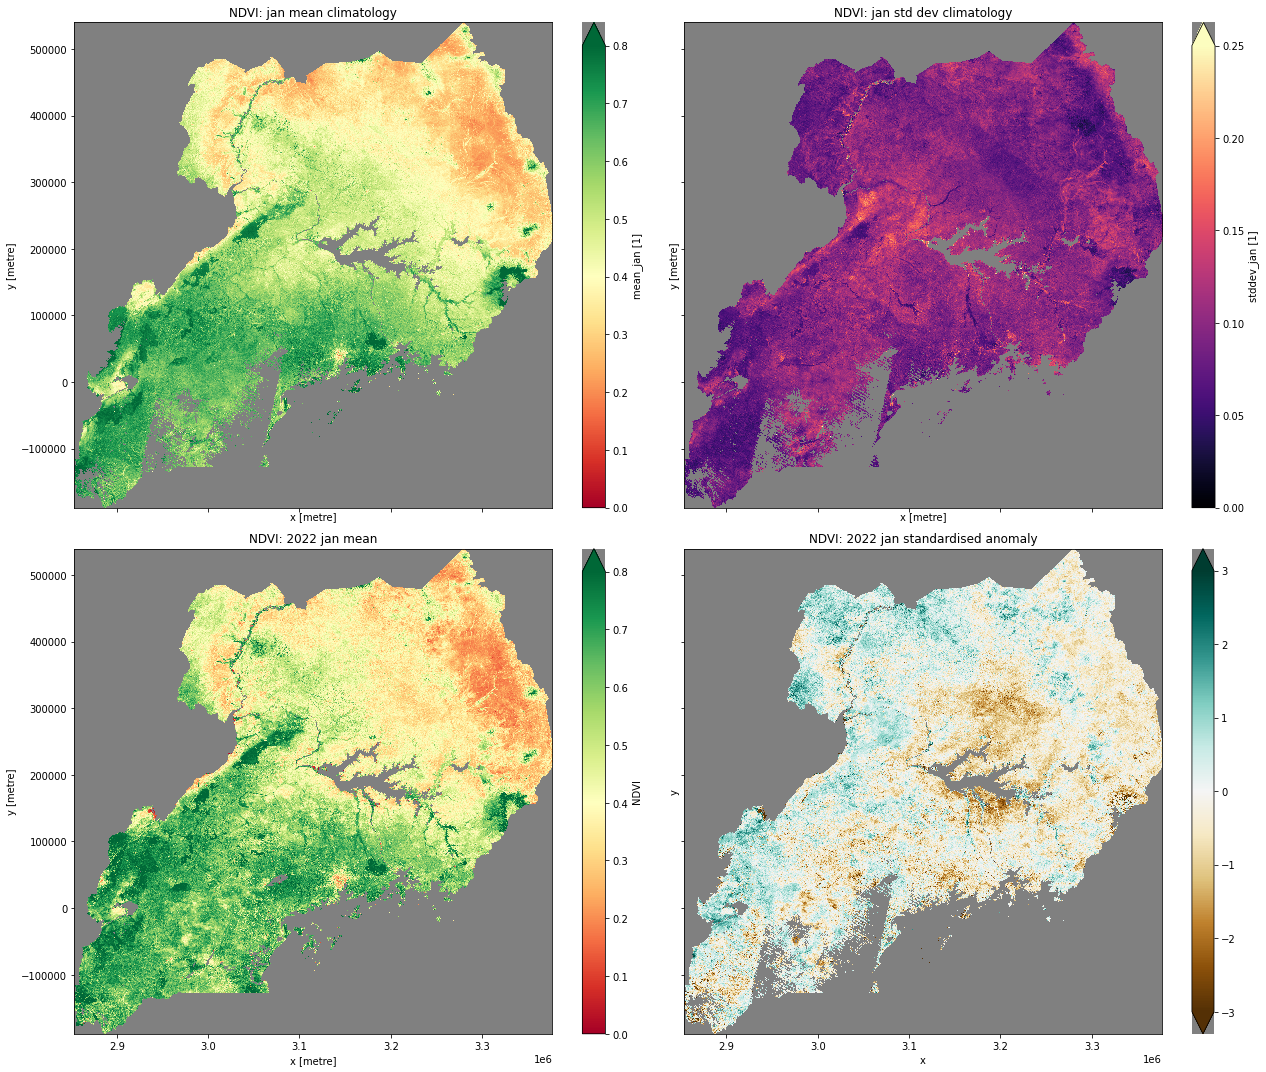

In [19]:
# plot al layers
plt.rcParams["axes.facecolor"] = "gray"  # makes transparent pixels obvious
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(18, 15))

mean_clim.plot.imshow(ax=ax[0, 0],cmap="RdYlGn",vmin=0,vmax=0.8)
ax[0, 0].set_title("NDVI: " + month + " mean climatology")

std_clim.plot.imshow(ax=ax[0, 1], cmap='magma', vmin=0, vmax=0.25)
ax[0, 1].set_title("NDVI: " + month + " std dev climatology")

month_mean.plot.imshow(ax=ax[1, 0], cmap="RdYlGn",vmin=0,vmax=0.8)
ax[1, 0].set_title("NDVI: " + year + " " + month + " mean")

stand_anomalies.plot.imshow(ax=ax[1, 1], cmap="BrBG", vmin=-3, vmax=3)
ax[1, 1].set_title("NDVI: " + year + " " + month + " standardised anomaly")
plt.tight_layout();

## Incorporating DE Africa's cropland extent map

Load the cropland mask over the region of interest. The default analysed here is in Ethiopia, so we need to load the [crop_mask_eastern](https://docs.digitalearthafrica.org/en/latest/data_specs/Cropland_extent_specs.html) product, which cover the countries of Ethiopia, Kenya, Tanzania, Rwanda, and Burundi.

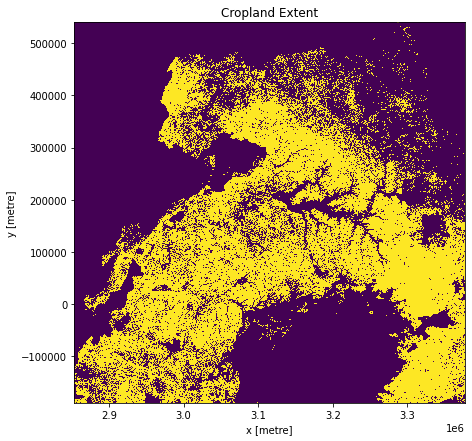

In [20]:
cm = dc.load(product=crop_mask,
            time=('2019'),
            measurements='mask', 
            resampling='nearest', 
            like=ds_ls.geobox).mask.squeeze()

cm.where(cm<255).plot.imshow(add_colorbar=False, figsize=(7,7))
plt.title('Cropland Extent');

### Plot NDVI climatolgies, monthly mean, and anomalies for cropping regions only

Below we mask out the regions that aren't cropping, revealing only the condition of the cropped regions. 

In [21]:
#mask layers with crop-mask
mean_clim_crop=mean_clim.where(cm==1, np.nan)
std_clim_crop=std_clim.where(cm==1, np.nan)
month_mean_crop=month_mean.where(cm==1, np.nan)
stand_anomalies_crop=stand_anomalies.where(cm==1, np.nan)

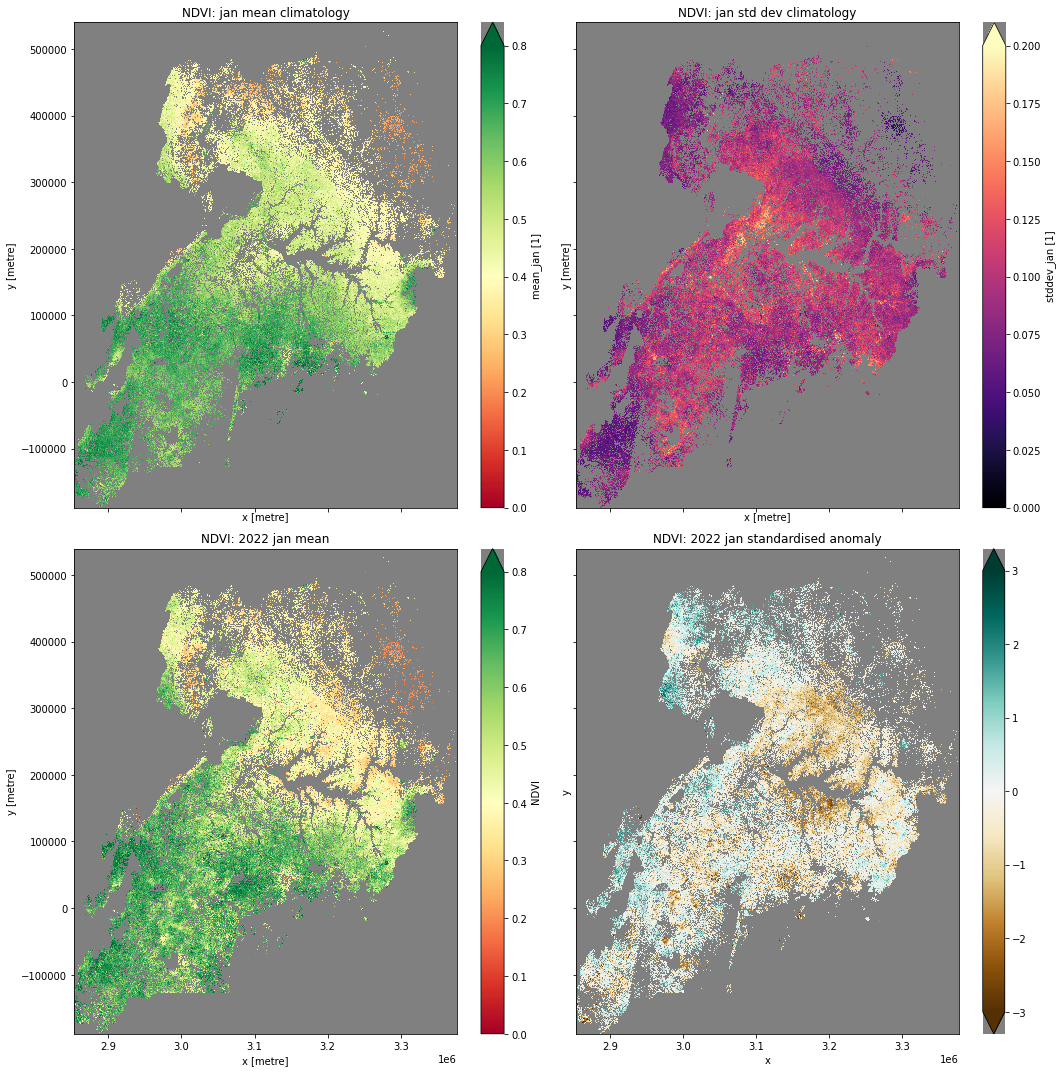

In [22]:
#plot al layers
plt.rcParams['axes.facecolor'] = 'gray' # makes transparent pixels obvious
fig,ax = plt.subplots(2,2, sharey=True, sharex=True, figsize=(15,15))

mean_clim_crop.plot.imshow(ax=ax[0,0], cmap='RdYlGn' ,vmin=0, vmax=0.8)
ax[0,0].set_title('NDVI: '+month+' mean climatology')

std_clim_crop.plot.imshow(ax=ax[0,1], cmap='magma', vmin=0, vmax=0.2)
ax[0,1].set_title('NDVI: '+month+' std dev climatology')

month_mean_crop.plot.imshow(ax=ax[1,0], cmap="RdYlGn",vmin=0,vmax=0.8)
ax[1,0].set_title('NDVI: '+year+" "+month+' mean')

stand_anomalies_crop.plot.imshow(ax=ax[1,1], cmap='BrBG',vmin=-3, vmax=3)
ax[1,1].set_title('NDVI: '+year+" "+month+' standardised anomaly')
plt.tight_layout();

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [23]:
print(datacube.__version__)

1.8.6


**Last Tested:**

In [24]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-04-27'